# 🛬 Import

In [1]:
from math import sqrt

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from scipy.spatial import distance

# 💾 Load Data

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')

# 👀 Data Exploration

Here we get familiar with the data <br>

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**📝 Takeaways** 
* Fare ranges between 0 - 512.3, SibSp between 0 - 8. This is a wide range and will be adressed during Pre Processing
* It also looks like Pclass could be modeled as a categorical feature


In [7]:
print(f"Pclass n of unique values: {df_train['Pclass'].nunique()}")
print(f"Pclass unique values:      {df_train['Pclass'].unique()}")

Pclass n of unique values: 3
Pclass unique values:      [3 1 2]


In [8]:
df_train['Pclass'] = df_train['Pclass'].map({1:'Upper', 2:'Middle', 3:'Lower'})
df_test['Pclass'] = df_test['Pclass'].map({1:'Upper', 2:'Middle', 3:'Lower'})

**📝 Takeaways** <br>
* Pclass has 3 unique values (1: Upper Class, 2: Middle Class, 3: Lower Class)
* We can translate it into a categorical feature


<br>While we are at, we can look at the other categorical features.

In [9]:
df_train.select_dtypes(include = 'object').nunique()

Pclass        3
Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [10]:
df_train['Embarked'] = df_train['Embarked'].map({'C':'Cherbourg', 'Q':'Queenstown', 'S':'Southampton'})
df_test['Embarked'] = df_test['Embarked'].map({'C':'Cherbourg', 'Q':'Queenstown', 'S':'Southampton'})

**📝 Takeaways**<br>
* Sex as defined in the data documentary: female, male
* Embarked can be mapped according to data documentation (C = Cherbourg, Q = Queenstown, S = Southampton) for clearer readablity

The other categorical features need a closer look, starting with Name.

In [11]:
df_train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [12]:
df_train['Name'].duplicated().any()

False

**📝 Takeaways**<br>
* The Name is mostly unstructured free text
* There are no duplicates in the train set
* The title (Mr., Ms., etc) is contained in the name, it might be interesting to scan for interesting titles such as acdemia, royalty or military

In [13]:
df_train['Name'].str.split().explode().value_counts()[:10]

Mr.        517
Miss.      182
Mrs.       125
William     62
John        44
Master.     40
Henry       33
James       24
Charles     23
George      22
Name: Name, dtype: int64

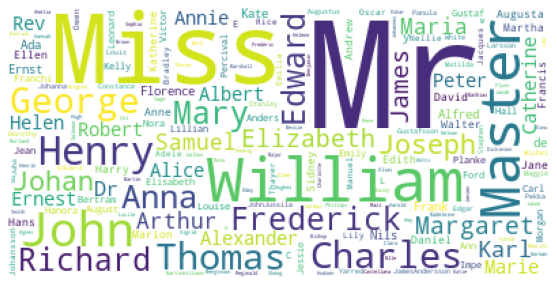

In [14]:
wordcloud = WordCloud(background_color = "white", relative_scaling=.5).generate(df_train['Name'].str.cat())
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**📝 Takeaways**
* William was a popular name in the early 20th century
* The titles mostly describe gender, which we already have stored in the feature Gender
* Master. title looks interesting, but is only the full form of Mr.

<figure>
    <blockquote cite="http://hwj.oxfordjournals.org/content/78/1/39.full">
        <p>‘Mistress’ is the root word of both of the abbreviations ‘Mrs’ and ‘Miss’, just as Mr is an abbreviation of ‘Master’. The ways that words derived from Mistress have developed their own meanings is fascinating and shifts in these meanings can tell us a lot about the changing status of women."</p>
    </blockquote>
    <figcaption>— Amy Erickson, <cite>Mistresses and Marriage: or, a Short History of the Mrs</cite></figcaption>
</figure>

Note: We might not have grabed every title, since we are going by frequency. However, if the title only occurs rarely, it is not interesting to us. In the wordcloud we can find Dr, but there are not enough occurances to factor it in.<br><br>
Let's look at Ticket next.

In [15]:
df_train['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [16]:
df_train['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

**📝 Takeaways**<br>
* Ticket seems to be unstructured and doesn't hold any relevant information
* Ticket should be removed during Pre Processing

The last categorical variable is Cabin.

In [17]:
df_train['Cabin'].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

In [18]:
m = df_train.shape[0]
df_train_cabin_na = (df_train['Cabin'].isnull().sum() / m) * 100
print(f'Percentage of NaN in Cabin: {round(df_train_cabin_na, 1)}%')

Percentage of NaN in Cabin: 77.1%


In [19]:
df_train['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

**📝 Takeaways** <br>

* Cabin is often NaN
* Cabin is mostly unstructured and can hold multiple tokens
* Cabin seems to describe the section of the ship and the number of the room

<p><img style="float:left; margin:20px; padding:20px; max-height:500px" src="https://www.ggarchives.com/DigitalAssets/Books/LossOfTheSteamshipTitanic/1912/89-TransverseAmidshipSectionOfTitanic-500.jpg"></p>
<p style="text-align:justify;">
    In this illustration, we can see that the decks range from A to G, so that assumption might be right. This would be interesting to extract and check for correlation to Survived.<br>
However, since there are 77% of the entries missing, we can't use this feature and will remove it in Pre Processing. <br>
In the next step, we should check the rest of the features for NaN values<br><br>
Image Source: <a href="https://www.ggarchives.com/OceanTravel/Titanic/25-Images-DeckPlans.html">ggarchives.com</a>

In [20]:
df_train.isnull().sum().sort_values(ascending = False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

**📝 Takeaways**<br>
* Cabin and Age have high NaN count
* Cabin should be removed in Pre Processing
* Age should be cleared in Pre Processing, as it has a lower NaN count and seems more promising
* Embarked should be cleared in Pre Processing

Now that we have a feel for the data, we will start visualizations.

# 📊 Data Visualization

## Survived

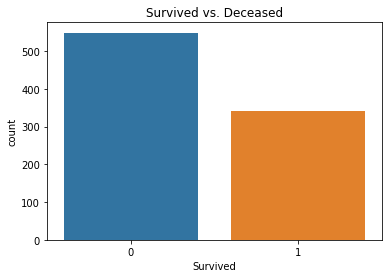

In [21]:
sns.countplot(x = df_train['Survived']).set_title('Survived vs. Deceased');

**📝 Takeaways**
* Just over a third of the people survied

## Sex

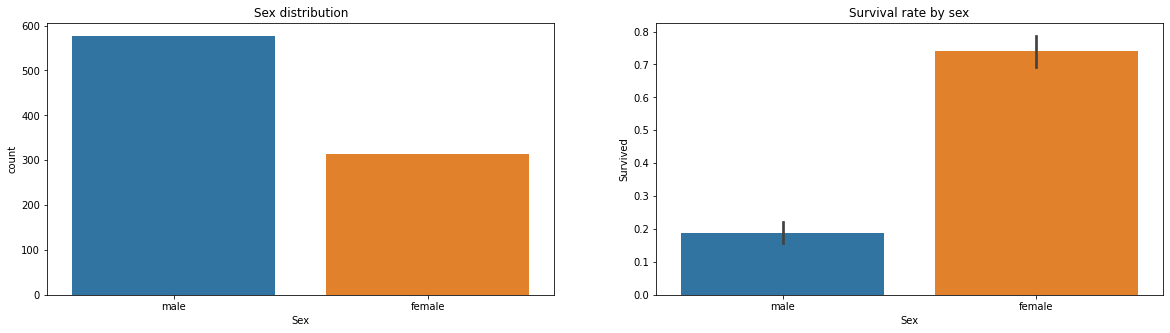

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.countplot(ax = axes[0], x = df_train['Sex']).set_title('Sex distribution')
sns.barplot(ax = axes[1], data = df_train, x = "Sex", y = "Survived").set_title('Survival rate by sex');

**📝 Takeaways**
* Most travelers were male
* The survival rate for females is higher

See: <a href="https://en.wikipedia.org/wiki/Women_and_children_first">Wikipedia</a>

## Pclass

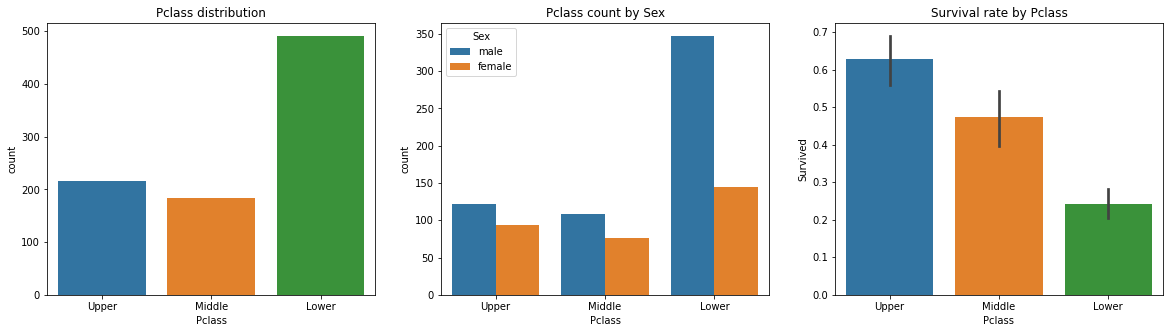

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

pclass_order = ["Upper", "Middle", "Lower"]

sns.countplot(ax = axes[0], x = df_train['Pclass'], order = pclass_order).set_title('Pclass distribution')
sns.countplot(ax = axes[1], data = df_train, x = 'Pclass', order = pclass_order, hue = 'Sex').set_title('Pclass count by Sex')
sns.barplot(ax = axes[2], data = df_train, x = "Pclass", y = "Survived", order = pclass_order).set_title('Survival rate by Pclass');

**📝 Takeaways**
* Most travelers were in the lower class
* There were a lot of men in the lower class
* Chance of survival growths with class

## Age

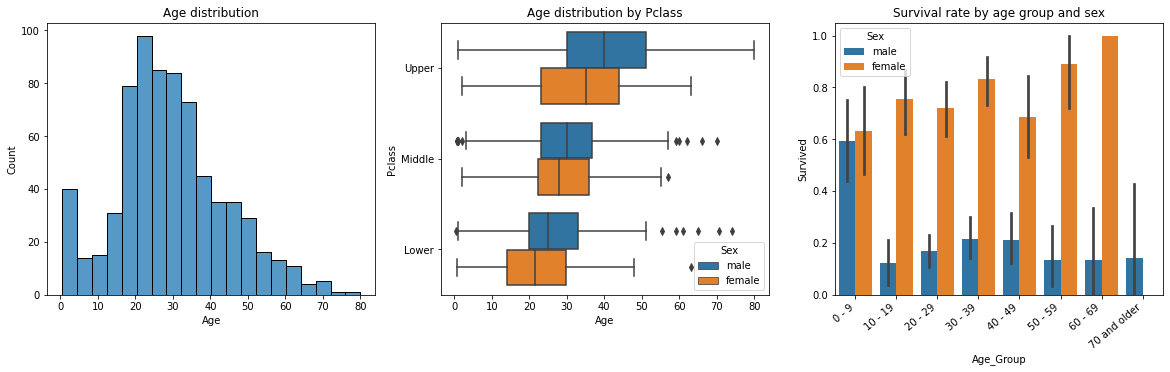

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(ax = axes[0], data=df_train, x="Age").set_title('Age distribution')
sns.boxplot(ax = axes[1], data=df_train, x="Age", y="Pclass", hue='Sex', order=["Upper", "Middle", "Lower"]).set_title('Age distribution by Pclass')

#Plot by age group

#Define age limit for groups and their labels
age_groups_thresholds = [0, 9, 19, 29, 39, 49, 59, 69, np.inf]
age_groups = ["0 - 9", "10 - 19", "20 - 29", "30 - 39", "40 - 49", "50 - 59", "60 - 69", "70 and older"]

#Cut Age Series by thresholds and load into new feature
df_train["Age_Group"] = pd.cut(df_train['Age'], age_groups_thresholds, labels=age_groups)
sns.barplot(ax = axes[2], data=df_train, x="Age_Group", y="Survived", hue="Sex").set_title('Survival rate by age group and sex')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation = 40, ha="right");

**📝 Takeaways**
* The Age is normal distributed with a positive skew
* The class tells us the general age group, with Lower having the youngest and Upper the oldest
* For males, children from 0 - 9 had the highest chance of surival, women in all age groups had high survival rate


It is interesting to see that women of old age had a higher survival rate than girls.

## SibSp

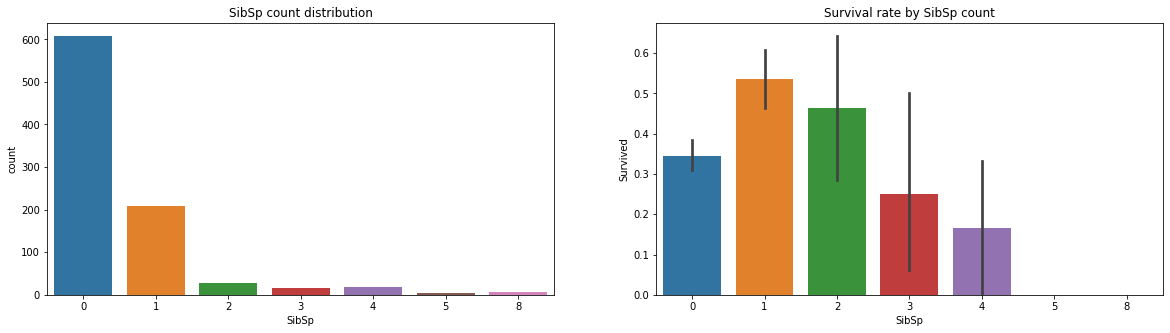

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.countplot(ax = axes[0], x = df_train['SibSp']).set_title('SibSp count distribution')
sns.barplot(ax = axes[1], data = df_train, x = "SibSp", y = "Survived").set_title('Survival rate by SibSp count');

**📝 Takeaways**
* The count of people gets lower with amount of siblings
* Having 1 or 2 siblings on board was good for surivival, more made it worse

## Parch

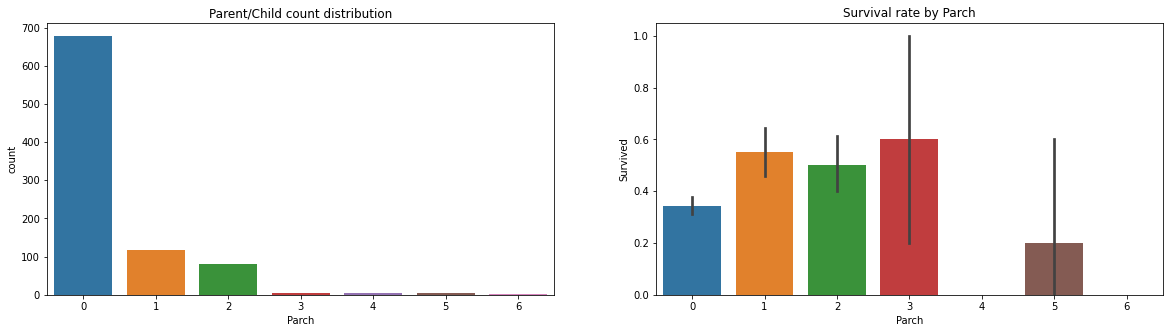

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.countplot(ax = axes[0], x = df_train['Parch']).set_title('Parent/Child count distribution')
sns.barplot(ax = axes[1], data = df_train, x = "Parch", y = "Survived").set_title('Survival rate by Parch');

**📝 Takeaways**
* Most peopöe had only a few or no parents / children on board
* There is no clear impact on surival rate

## Fare

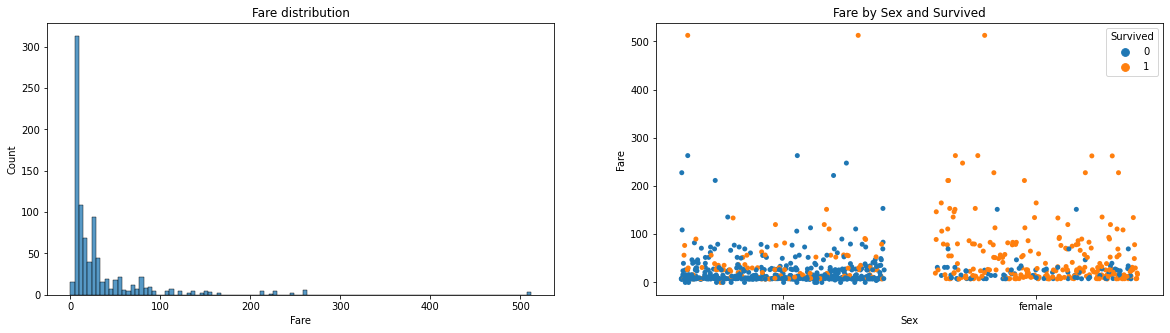

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(ax = axes[0], x = df_train["Fare"]).set_title('Fare distribution')
sns.stripplot(ax = axes[1], data = df_train, x="Sex", y="Fare", hue="Survived", jitter=0.4).set_title('Fare by Sex and Survived');

**📝 Takeaways**
* The Fare is normal  at around 10 with a few extreme outliers
* Only the outliers seem to have an impact on the survival rate, middle range Fares also had a bad survival chance for men
* Women with a low Fare also had a bad surival chance

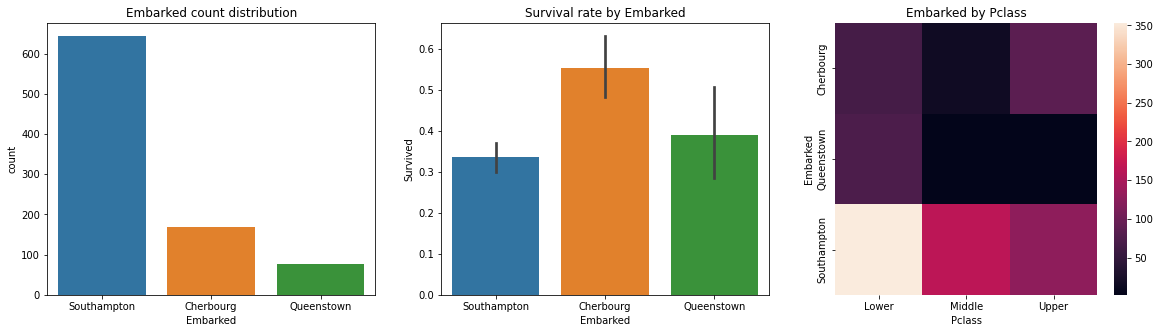

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
crosstable_joined_classdept = pd.crosstab(df_train['Embarked'], df_train['Pclass'])

sns.countplot(ax = axes[0], x = df_train['Embarked']).set_title('Embarked count distribution')
sns.barplot(ax = axes[1], data = df_train, x = "Embarked", y = "Survived").set_title('Survival rate by Embarked')
sns.heatmap(ax = axes[2], data = crosstable_joined_classdept).set_title('Embarked by Pclass');

**📝 Takeaways**
* Most people embarked in Southampton
* The people who embarked in Cherbourg had the best chance for surival
* There is no clear difference where people from classes embarked

We know that the Titanic was built in Belfast, then went to Southhampton, Cherbourg and Queenstown in that order.

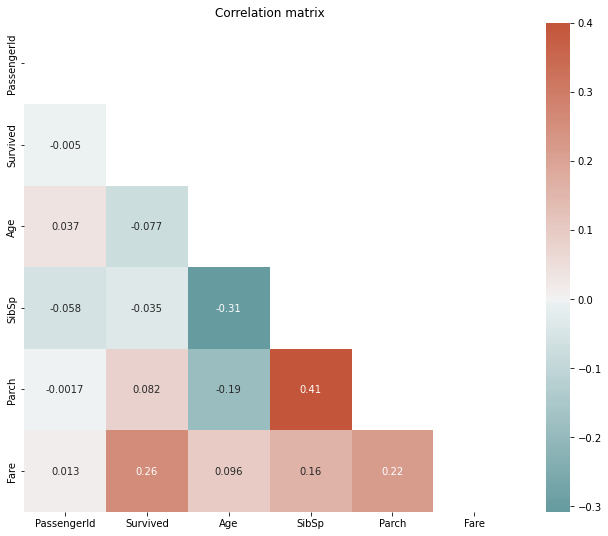

In [29]:
corr = df_train.corr()
plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(200, 20, as_cmap=True)
sns.heatmap(corr ,annot = True, mask=mask, cmap=cmap, vmax=.4, center=0).set_title('Correlation matrix');

**📝 Takeaways**
* Strongest correlation between Parch and SibSp, which comes from traveling families
* The fare has the highest correlation to survived

In the <a href="https://en.wikipedia.org/wiki/Women_and_children_first">Wikipedia</a> article from earlier it says
<figure>
    <blockquote cite="http://hwj.oxfordjournals.org/content/78/1/39.full">
        <p>"Notable invocations of the concept include during the 1852 evacuation of the Royal Navy troopship HMS Birkenhead and most famously during the 1912 sinking of RMS Titanic. Despite its prominence in the popular imagination, the doctrine was unevenly applied."</p>
    </blockquote>
    <figcaption>— Wikipedia, <cite>Women and children first (10.2022)</cite></figcaption>
</figure>
After looking at the Pclass and Fare features, we could definitely see a trend. The correlation between Fare and Survival confirms it. Money first would have been a more accurate code of conduct. However, we did see that children had the highest survival rate of all ages.

# ⚙️ Pre Processing

In this step we implement all the findings we evaluated in the last steps.

In [30]:
#Train
age_mean = df_train['Age'].mean()
df_train['Age'].fillna(round(age_mean),inplace=True)
df_train['Embarked'].fillna(method = 'bfill', inplace = True)

In [31]:
#Test
age_mean_test = df_test['Age'].mean()
df_test['Age'].fillna(round(age_mean_test),inplace=True)
df_test['Embarked'].fillna(method = 'bfill', inplace = True)

**📝 Takeaways**
* We fill up the missing Age values with the mean of all ages
* We fill up the missing Embarked values with backward fill, which will get the last avaiable value

In the next step, we will normalize the data to make it easier to work with. This will be important for the model predictions. <br><br>
For **numeric data**, we standardize it by normalizing the min max to be inbetween 0 and 1. This makes the weight of all numeric features equal. More about that later. <br><br>
For **categorical data**, we use <a href='https://en.wikipedia.org/wiki/One-hot'>one hot encoding</a>. Let's look at Pclass for an example: <br><br>
Pclass can hold 3 values (0: Upper, 1: Middle, 2: Lower). To work with the data, we need numbers. We could represent the data by its index. However, this does not make sense, since it does not represent the relationship between the categories well. This is why we want to represent categorical data as a vector. The vector is a list of zeros with the exact length of possible values of the categorical variable. On the index of the given categorical value, a 1 will be set. <br><br>

Example: <br>

<img src='https://miro.medium.com/max/1400/1*ggtP4a5YaRx6l09KQaYOnw.png'> <br><br>

Image Source: <a href='https://towardsdatascience.com/building-a-one-hot-encoding-layer-with-tensorflow-f907d686bf39'>towardsdatascience.com</a>

In [32]:
#Scale all numeric features to 0 - 1
def scale(num_features):
    min_max_scaler = MinMaxScaler()
    num_features = min_max_scaler.fit_transform(num_features)
    return pd.DataFrame(num_features)

#One hot encode categorical features
def one_hot_encode(cat_features):
    one_hot_enc = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
    cat_features_one_hot = pd.DataFrame(one_hot_enc.fit_transform(cat_features))
    return pd.DataFrame(cat_features_one_hot)

#Normalize data according to data type
def normalize_data(df):
    cat_features = df.select_dtypes(include = 'object')
    num_features = df.select_dtypes(exclude = 'object')
    
    cat_features = one_hot_encode(cat_features)
    num_features = scale(num_features)

    df = pd.concat([num_features, cat_features], axis = 1)
    return df.to_numpy()

In [33]:
#Train
X = df_train[['Age', 'Fare', 'SibSp', 'Parch', 'Sex', 'Pclass', 'Embarked']]
X = normalize_data(X)

y = df_train['Survived'].to_numpy()

X_train, X_dev, y_train, y_dev = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 0)

In [34]:
#Test
X_test = df_test[['Age', 'Fare', 'SibSp', 'Parch', 'Sex', 'Pclass', 'Embarked']]
X_test = normalize_data(X_test)

**📝 Takeaways**
* We choose the train features X which we discussed in the Data Exploration
* We take Survived for the goal variable y
* We split the data in train and dev for cross validation

We do not want to use the test set for validation while training models. The test data should remain unknown until a model has been selected, as it should simulate future predictions. So we have to split the train data into train and dev. <br>

# 🧰 Model

[$k$-Nearest-Neighbours](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) (kNN) uses the spacial distance between points in the data set. For every entry in x_test, we check its nearest $k$ neighbours in the x_train. We then take the average of the corresponding real  y value of the neighbours and check if it is greater than 0.5, to get a binary prediction.

\begin{equation}
\frac{1}{k}
\sum_{i=1}^{m}
y^{(i)}
> 0.5
\end{equation}

Or in simpler terms, if we imagine every feature in our data as a dimension, we can find the distance to each other. This is easiest to think about with 2 features, which will create a 2D plane (see below). When we fit a new data point from x_test, we check the distance from that point to all data points in x_train. Then, we take the $k$ nearest neighbours, meaning the points from x_train with the lowest distance. Now we can calcualte the average of all corresponding y_train data points and check if it is greater than 0.5. <br><br>

For example, if the nearest k=5 neighbours y values are [1, 1, 0, 1, 0], we get an average of 3 / 5 = 0.6. Since 0.6 is greater than 0.5, we will predict it as survived.<br><br>

<center><img src='http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final_a1mrv9.png'></center><br><br>
Image Source: <a href='https://towardsdatascience.com/knn-k-nearest-neighbors-1-a4707b24bd1d'>towardsdatascience.com</a>

The euclideanb distance between two points is calculated by
\begin{equation}
d\left( a,b\right) = \sqrt {\sum _{i=1}^{n}  \left( a_{i}-b_{i}\right)^2 } 
\end{equation}

<div class="alert alert-block alert-info">
<b>ℹ️ Note:</b> We are subtracting the features from each other. This is why we needed to scale the numeric features. If one feature has much higher values than others, it will lead to larger numbers. This will make the distance higher and give the feature more weight during prediction.
</div>

In [35]:
class KNearestNeighbourEstimator():
    def __init__(self, k_):
        self.k_ = k_
        
    def fit(self, X, y):
        self.X_train_ = X
        self.y_train_ = y
    
    def predict(self, X_test):
        predictions = []
        
        #Go through each line in X_test and get prediction (0 or 1)
        for X_test_row in X_test:
            output = self.__row_prediction(X_test_row)
            predictions.append(output)
            
        return(predictions)
    
    # Make a prediction of a single row in X_test
    def __row_prediction(self, X_test_row):
        #Get indices of k nearest neighbours and collect y values
        k_neighbours_indices = self.__get_k_nearest_neighbours_indices(X_test_row)
        k_neighbours_y_values = self.y_train_[k_neighbours_indices]
        
        #Get average of y values
        average = 0
        for y_value in k_neighbours_y_values:
            average += y_value
        average = average / len(k_neighbours_y_values)
        
        #Check if neighbours are more likely to show survival
        prediction = average > 0.5

        return int(prediction)
    
    #Get list of k neighbours indices for X_test_row
    def __get_k_nearest_neighbours_indices(self, X_test_row):
        distances = []
        
        #Get index and distance to each row in X_train for X_test row
        for i, X_train_row in enumerate(self.X_train_):
            distance = self.__euclidean_distance(X_test_row, X_train_row)
            distances.append((i, distance))
        
        #Sort by distance value
        distances.sort(key=lambda tup: tup[1])
        
        #Get the indices of the top k neighbours
        k_neighbours = []
        for i in range(self.k_):
            k_neighbours.append(distances[i][0])
        return k_neighbours
    
    #Calculate euclidean distance according to equation
    def __euclidean_distance(self, a, b):
        distance = 0
        for i in range(len(a) - 1):
            distance += (a[i] - b[i])**2
        return sqrt(distance)

In [36]:
knn_estimator = KNearestNeighbourEstimator(k_ = 5)
knn_estimator.fit(X_train, y_train)
y_pred = knn_estimator.predict(X_dev)
accuracy = accuracy_score(y_dev, y_pred)

print(f'Accuracy with k = 5: {round(accuracy, 2)}')

Accuracy with k = 5: 0.81


<div class="alert alert-block alert-danger">  
<b>⚠️ Too many For-loops:</b> Looks good, right? Judging by the score the implementation seems to work. However, this implementation is flawed. It does not use the full power of Python and numpy. Python For-loops are known to be slow.
</div>

To get rid of the For-loops, we will use [vectorization](https://en.wikipedia.org/wiki/Array_programming). This will use numpy to do matrix multiplications instead of For-loops. In numpy, these are implemented in C below Python, which makes them faster. If you want to learn more about matrix multiplications, I suggest the [3Blue1Brown video](https://www.youtube.com/watch?v=XkY2DOUCWMU) on the topic.

In [37]:
class KNearestNeighbourEstimatorVect():
    def __init__(self, k_):
        self.k_ = k_
    
    def fit(self, X, y):
        self.X_ = X
        self.y_ = y

    def predict(self, X):
        distances = distance.cdist(X, self.X_, 'euclidean')
        i_k_smallest = np.argpartition(distances, self.k_)[:,:self.k_]
        values = self.y_[i_k_smallest]
        predictions = np.average(values, axis=1) > 0.5
        return 1*predictions

The implementation is also much shorter than the unvectorized implementation. Let's go through each line of the prediction:<br><br>
1. `distances = distance.cdist(X, self.X_, 'euclidean')`<br>
The method cdist takes over the row by row calcuation of the euclidean distance. It returns a matrix that has the number of rows like X_train, but each row contains the distance to each point in X_test. So the column number will be equal to the number of rows in X_test.
<br><br>

1. `i_k_smallest = np.argpartition(distances, self.k_)[:,:self.k_]`<br>
With argpartition, we get the indices of each distance. The first k rows will be the indices with the lowest distance. [:,:self.k_] slices these rows off, so we only get the relevant k neighbour indices.
<br><br>

1. `values = self.y_[i_k_smallest]`<br>
Get the values of y_train by the indices.
<br><br>

1. `predictions = np.average(values, axis=1) > 0.5`<br>
Get the average of each row in the matrix, which will result in a matrix that has only one column, which contains each average as number. Then we check for each row, if the value is grater than 0.5. Since a boolean can be mapped to 0 or 1, this will result in our predictions.
<br><br>

Now, let's compare the running time.

In [38]:
%%time
itterations = 10

for i in range(itterations):
    knn_estimator = KNearestNeighbourEstimator(k_ = 711)
    knn_estimator.fit(X_train, y_train)
    y_pred = knn_estimator.predict(X_dev)

CPU times: user 9.89 s, sys: 0 ns, total: 9.89 s
Wall time: 9.9 s


In [39]:
%%time
itterations = 10

for i in range(itterations):
    knn_estimator = KNearestNeighbourEstimatorVect(k_ = 711)
    knn_estimator.fit(X_train, y_train)
    y_pred = knn_estimator.predict(X_dev)

CPU times: user 24.6 ms, sys: 0 ns, total: 24.6 ms
Wall time: 24.1 ms


Thats a speed up of over **300x**, with only 20 iterations 💨 <br><br>

Now that we are confident of our models speed, we can brute force the best k for this data set.

In [40]:
m = len(y_train)

best_accuracy =  float('-inf')
best_k = -1
for k in range(1, m):
    knn_estimator = KNearestNeighbourEstimatorVect(k_ = k)
    knn_estimator.fit(X_train, y_train)
    y_pred = knn_estimator.predict(X_dev)
    accuracy = accuracy_score(y_dev, y_pred)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
        best_y_pred = y_pred
        
print(f'Best k: {best_k}')
print(f'Score:  {round(best_accuracy, 2)}')

Best k: 76
Score:  0.83


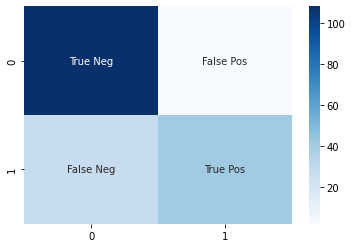

In [41]:
confusion_m = confusion_matrix(y_dev, best_y_pred)

labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_m, annot = labels, fmt = '', cmap = 'Blues');

We get a score of 0.83! <br>
In the confusion matrix, we see that most errors stem from False Negatives. As we saw in the visualization, the Survived values are not equally distributed. This explains the unqual error rate.

# 📨 Submission

In [42]:
knn_estimator = KNearestNeighbourEstimatorVect(k_ = best_k)
knn_estimator.fit(X_train, y_train)
y_pred = knn_estimator.predict(X_test)

In [43]:
#Create output file
output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_pred})
output.to_csv('submission.csv', index = False)

In [44]:
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
